## Imports & Parameters

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Standard library imports
import datetime
import json
import locale
import os

# Third-party imports
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import linalg as la
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch.nn.functional as F
from timeit import default_timer as timer
from google.colab import files

# Seed for reproducibility
seed = 42
torch.manual_seed(seed)

# Data
BATCH_SIZE = 64
WINDOW_SIZE = 40

# ENCODER
E_INPUT_CHANNELS = 84
E_HIDDEN_CHANNELS = 512
E_OUTPUT_CHANNELS = 512

# VQ
BETA = 0.25
NUM_CODEVECTORS = 512
DIM_CODEVECTORS = 32

# DECODER
D_INPUT_CHANNELS = 512
D_HIDDEN_CHANNELS = 512
D_OUTPUT_CHANNELS = 84

# Training
EPOCHS = 200
LEARNING_RATE = 1e-3

# Device Agnostics
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model Loading
train_stored_model = False
evaluate_stored_model = False

# Paths
TRAIN_FOLDER = "/content/drive/MyDrive/Signs!_Project/preprocessed_data"
TEST_FOLDER = "/content/drive/MyDrive/Signs!_Project/test_data_preprocessed"
STORED_MODELS = "/content/drive/MyDrive/Signs!_Project/stored_models"
RECONSTRUCTED_DATA = "/content/drive/MyDrive/Signs!_Project/reconstructed_data"

# File Names
LOADED_MODEL_NAME = "testing_100_epochs"
MODEL_NAME = f"VQ_VAE_{EPOCHS}_epochs_{BATCH_SIZE}_batch_size_{NUM_CODEVECTORS}_code_vectors_{DIM_CODEVECTORS}_code_dim"
TRUE_X = f"true_X_{EPOCHS}_epochs_{BATCH_SIZE}_batch_size_{NUM_CODEVECTORS}_code_vectors_{DIM_CODEVECTORS}_code_dim"
RECON_X = f"recon_X_{EPOCHS}_epochs_{BATCH_SIZE}_batch_size_{NUM_CODEVECTORS}_code_vectors_{DIM_CODEVECTORS}_code_dim"

# Data


In [ ]:
def get_data(folder):
  """
    Reads data from a specified folder, processes it into batches, and returns a tensor.

    Parameters:
    - folder (str): The path to the folder containing the data files.

    Returns:
    - torch.Tensor: A PyTorch tensor containing the processed data.
    """
  dataset = []

  # Iterate over each file in the specified folde
  for filename in os.listdir(folder):
    video_path = folder + "/" + filename

    # Load the JSON file into a DataFrame
    with open(video_path, 'r') as file:
      data = pd.read_json(file)

    # Determine the number of batches we can create from this file based on the window size
    num_batches = len(data.columns) // WINDOW_SIZE

    # Process the data into batches and append to the dataset
    for batch_id in range(num_batches):
      start_idx = batch_id * WINDOW_SIZE
      end_idx = (batch_id + 1) * WINDOW_SIZE
      batch_df = data.iloc[:,start_idx:end_idx].astype(np.float64)
      dataset.append(batch_df.values)

  # Convert the NumPy array to a PyTorch tensor
  tensor = torch.tensor(dataset)

  return tensor


train_dataset = get_data(TRAIN_FOLDER)  # Time Windows x 84 x 24
test_dataset = get_data(TEST_FOLDER)    # Time Windows x 84 x 24

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"The training data loader has {len(train_loader)} batches of data")
print(f"The test data loader has {len(test_loader)} batches of data")

<ipython-input-3-c915050f64a4>:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  tensor = torch.tensor(dataset)


The training data loader has 6 batches of data
The test data loader has 2 batches of data


# Model

### Residual Block

In [ ]:
class RB(nn.Module):
  """
    Residual Block (RB) for the VQ-VAE model, consisting of two convolutional layers with ReLU activations in between.

    Parameters:
    - _padding (int): The amount of padding added to all sides of the input.
    - _dilation (int): The spacing between kernel elements.
    - channels (int): The number of input and output channels.

    Attributes:
    - ResBlock (nn.Sequential): A sequential container that encapsulates the residual block's layers, including two convolutional layers with ReLU activations in between.

    Methods:
    - forward(self, x): Performs the forward pass of the residual block, applying the block's operations to the input tensor and adding the result to the original input.
  """
  def __init__(self,
               _padding: int,
               _dilation: int,
               channels: int):
    super().__init__()
    self.ResBlock = nn.Sequential(
        nn.ReLU(),
        nn.Conv1d(in_channels=channels,
                  out_channels=channels,
                  kernel_size=3,
                  stride=1,
                  padding=_padding,
                  dilation=_dilation),
        nn.ReLU(),
        nn.Conv1d(in_channels=channels,
                  out_channels=channels,
                  kernel_size=1,
                  stride=1,
                  padding=0,
                  dilation=1),
    )

  def forward(self, x):
    """
      Forward pass through the Residual Block.

      Parameters:
      - x (torch.Tensor): Input tensor.

      Returns:
      - torch.Tensor: Output tensor after applying the Residual Block.
    """
    return x + self.ResBlock(x)

### Encoder

In [ ]:
class Encoder(nn.Module):
  """
    Encoder for the VQ-VAE model, consisting of a series of convolutional and residual blocks that downsample
    the input.

    Parameters:
    - _in_channels (int): The number of input channels, corresponding to the number of joint landmarks.
    - _hidden_channels (int): The number of hidden channels in the convolutional layers.
    - _out_channels (int): The number of output channels from the last convolutional layer, which is also the input size for the vector quantization module.

    Attributes:
    - encode (nn.Sequential): A sequential container that encapsulates the encoder's layers, including convolutional layers and residual blocks.

    Methods:
    - forward(self, x): Performs the forward pass of the encoder, downsampling the input and transforming it into a latent representation.
  """
  def __init__(self,
               _in_channels: int,
               _hidden_channels: int,
               _out_channels: int):
    super().__init__()
    self.encode = nn.Sequential(
        # N x IN_C x L --> N x H_C x L/2
        nn.Conv1d(in_channels=_in_channels,
                  out_channels=_hidden_channels,
                  kernel_size=4,
                  stride=2,   # Halves the length
                  padding=1,
                  dilation=1),
        # Doesn't change the shape, but helps with the vanishing gradient problem
        RB(_padding=1,
           _dilation=1,
           channels=_hidden_channels),
        # N x H_C x L/2 --> N x H_C x L/4
        nn.Conv1d(in_channels=_hidden_channels,
                  out_channels=_hidden_channels,
                  kernel_size=4,
                  stride=2,   # Halves the length
                  padding=1,
                  dilation=1),
        RB(_padding=3,
           _dilation=3,
           channels=_hidden_channels),
        # N x H_C x L/4 --> N x H_C x L/8
        nn.Conv1d(in_channels=_hidden_channels,
                  out_channels=_hidden_channels,
                  kernel_size=4,
                  stride=2,   # Halves the length
                  padding=1,
                  dilation=1),
        RB(_padding=9,
           _dilation=9,
           channels=_hidden_channels)
    )

  def forward(self, x):
    """
      Forward pass through the Encoder.

      Parameters:
      - x (torch.Tensor): Input tensor.

      Returns:
      - torch.Tensor: Output tensor after encoding.
    """
    return self.encode(x.float())


### Decoder

In [ ]:
class Decoder(nn.Module):
  """
    Decoder for the VQ-VAE model, consisting of transposed convolutional layers and residual blocks to upsample
    the encoded tensor back to the original input size.

    Parameters:
    - _in_channels (int): The number of input channels, corresponding to the number of hidden channels from the encoder.
    - _hidden_channels (int): The number of hidden channels in the convolutional layers.
    - _out_channels (int): The number of output channels from the last convolutional layer, corresponding to the number of joint landmarks.

    Attributes:
    - decode (nn.Sequential): A sequential container that encapsulates the decoder's layers, including transposed convolutional layers and residual blocks.

    Methods:
    - forward(self, codes): Performs the forward pass of the decoder, upsampling the encoded tensor and transforming it back into the original input size.
 """
  def __init__(self,
                _in_channels: int,
               _hidden_channels: int,
               _out_channels: int):
    super().__init__()
    self.decode = nn.Sequential(
        RB(_padding=9,
           _dilation=9,
           channels=_hidden_channels),
        # N x IN_C x L' --> N x H_C x 2*L'
        nn.ConvTranspose1d(in_channels=_hidden_channels,
                          out_channels=_hidden_channels,
                          kernel_size=4,
                          stride=2,   # doubles the length
                          padding=1,
                          dilation=1),
        RB(_padding=3,
           _dilation=3,
           channels=_hidden_channels),
        # N x H_C x 2*L' --> N x H_C x 4*L'
        nn.ConvTranspose1d(in_channels=_hidden_channels,
                          out_channels=_hidden_channels,
                          kernel_size=4,
                          stride=2,   # doubles the length
                          padding=1,
                          dilation=1),
        RB(_padding=3,
           _dilation=3,
           channels=_hidden_channels),
        # N x H_C x 4*L' --> N x H_C x 8*L'
        nn.ConvTranspose1d(in_channels=_hidden_channels,
                          out_channels=_hidden_channels,
                          kernel_size=4,
                          stride=2,   # doubles the length
                          padding=1,
                          dilation=1),
        # N x H_C x 8*L' --> N x OUT_C x 8*L'
        nn.Conv1d(in_channels=_hidden_channels,
                  out_channels=_out_channels,   # change num of channels to original sample amount
                  kernel_size=3,
                  stride=1,
                  padding=1,
                  dilation=1),
    )

  def forward(self, codes):
    """
      Forward pass through the Decoder.

      Parameters:
      - codes (torch.Tensor): Encoded tensor.

      Returns:
      - torch.Tensor: Output tensor after decoding.
    """
    return self.decode(codes)


### Vector Quantization

In [ ]:
class VQ(nn.Module):
  """
    Vector Quantization (VQ) module for the VQ-VAE model, using two codebooks (L and R) to quantize the input
    embeddings into discrete latent vectors.

    Parameters:
    - num_codes (int): The number of gesture primitives, determining the size of the codebooks used for vector quantization.
    - dim_codes (int): The dimensionality of each gesture primitive, and hence the dimensionality of each code vector in the codebooks.
    - beta (int): The hyperparameter controlling the commitment loss, which encourages the model to commit to the closest code vector.

    Attributes:
    - num_embeddings (int): The number of gesture primitives, derived from `num_codes`.
    - dim_embeddings (int): The dimensionality of each gesture primitive, derived from `dim_codes`.
    - codebook (nn.Embedding): The hand codebook with `num_embeddings` embeddings of dimension `dim_embeddings`. This codebook is used to quantize the input embeddings into discrete latent vectors.
    - commitment (int): The hyperparameter `beta`, which is used to control the commitment loss.

    Methods:
    - find_nearest_neighbour(self, flatten_inputs, code_vectors): Computes the nearest neighbour for each input vector in the flattened inputs
    - forward(self, z_e): Performs the forward pass of the VQ module, quantizing the continuous latent vectors into discrete codes.

    References:
    - VQ implementation inspired by https://github.com/explainingai-code/VQVAE-Pytorch/blob/main/model/quantizer.py
  """
  def __init__(self,
               num_codes: int,
               dim_codes: int,
               beta: int):
    super().__init__()
    self.num_embeddings = num_codes
    self.dim_embeddings = dim_codes
    self.codebook = nn.Embedding(num_embeddings=self.num_embeddings,
                                 embedding_dim=self.dim_embeddings)
    self.commitment = beta

    self.codebook.weight.data.uniform_(-1.0 / self.num_embeddings, 1.0 / self.num_embeddings)

  def find_nearest_neighbour(self, flatten_inputs, code_vectors):
    """
    Computes the nearest neighbour for each input vector in the flattened inputs.

    Parameters:
    - flatten_inputs (torch.Tensor): The flattened input embeddings.
    - code_vectors (torch.Tensor): The code vectors from the codebook.

    Returns:
    - torch.Tensor: The indices of the nearest neighbours in the codebook for each input vector.
    """
    # Compute the L2 distance between each input vector and each embedding.
    distances = (
        torch.sum(flatten_inputs ** 2, dim=1, keepdim=True) +
        torch.sum(code_vectors ** 2, dim=0) -
        2 * torch.matmul(flatten_inputs, code_vectors)
    )

    _, indices = torch.min(distances, dim=-1)

    return indices

  def forward(self, z_e):
    """
    Performs the forward pass of the VQ module, quantizing the continuous latent vectors into discrete codes.

    Parameters:
    - z_e (torch.Tensor): The continuous latent vectors from the encoder.

    Returns:
    - loss (torch.Tensor): The total loss, including codebook loss and commitment loss.
    - quantized (torch.Tensor): The quantized latent vectors.
    - perplexity (torch.Tensor): The perplexity of the quantized codes.
    - encodings (torch.Tensor): The one-hot encoded indices of the nearest code vectors.
    """
    # N x C x L --> N x L x C
    z_e = z_e.permute(0,2,1).contiguous()

    original_shape = z_e.shape
    flat_z_e = z_e.view(-1, self.dim_embeddings) # N x L x C --> (N*L*C) / embeddin_size --> N*L x C

    # Calculate distances
    distances = (torch.sum(flat_z_e**2, dim=1, keepdim=True)
                + torch.sum(self.codebook.weight**2, dim=1)
                - 2 * torch.matmul(flat_z_e, self.codebook.weight.t()))

    # Encoding
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.nn.functional.one_hot(encoding_indices, self.num_embeddings).float()

    # Quantize and unflatten
    quantized = torch.matmul(encodings, self.codebook.weight).view(original_shape)

    # Loss
    codebook_loss = F.mse_loss(quantized.detach(), z_e)
    commitment_loss = F.mse_loss(quantized, z_e.detach())
    loss = codebook_loss + self.commitment * commitment_loss

    # Straight-through gradient estimator
    quantized = z_e + (quantized - z_e).detach()

    # Perplexity
    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

    # convert quantized from NLC -> NCL
    return loss, quantized.permute(0, 2, 1).contiguous(), perplexity, encodings



### VQ-VAE

In [ ]:
class VQ_VAE(nn.Module):
  """
    Vector Quantized Variational Autoencoder (VQ-VAE) model.

    Parameters:
    - E_in_channels (int): The number of input channels for the encoder, corresponding to the number of joint landmarks.
    - E_hidden_channels (int): The number of hidden channels in the encoder.
    - E_out_channels (int): The number of output channels from the encoder, which is also the input size for the vector quantization module.
    - D_in_channels (int): The number of input channels for the decoder, corresponding to the number of hidden channels from the encoder.
    - D_hidden_channels (int): The number of hidden channels in the decoder.
    - D_out_channels (int): The number of output channels from the decoder, corresponding to the number of joint landmarks.
    - num_codes (int): The number of gesture primitives, determining the size of the codebook used for vector quantization.
    - dim_codes (int): The dimensionality of each gesture primitive, and hence the dimensionality of each code vector in the codebook.
    - beta (int): The hyperparameter controlling the commitment loss, which encourages the model to commit to the closest code vector.

    Attributes:
    - encoder (Encoder): The encoder module, responsible for downsampling the input.
    - pre_vq (nn.Conv1d): A convolutional layer that adjusts the dimensionality of the encoder's output to match the dimensionality of the code vectors.
    - vq (VQ): The vector quantization module, which quantizes the encoder's continuous latent vectors into discrete codes using a codebook.
    - post_vq (nn.Conv1d): A convolutional layer that adjusts the dimensionality of the quantized codes to match the input size of the decoder.
    - decoder (Decoder): The decoder module, responsible for upsampling the quantized codes back to the original input shape.

    Methods:
    - forward(x): The forward pass of the model, which encodes the input, quantizes the
                  encoded vectors, and then decodes the quantized codes to produce the output.
  """
  def __init__(self,
               E_in_channels: int,
               E_hidden_channels: int,
               E_out_channels: int,
               D_in_channels: int,
               D_hidden_channels: int,
               D_out_channels: int,
               num_codes: int,
               dim_codes: int,
               beta: int):
    super().__init__()
    self.encoder = Encoder(E_in_channels, E_hidden_channels, E_out_channels)
    self.pre_vq = nn.Conv1d(in_channels=E_out_channels,
                  out_channels=dim_codes,
                  kernel_size=1,
                  stride=1)
    self.vq = VQ(num_codes, dim_codes, beta)
    self.post_vq = nn.Conv1d(in_channels=dim_codes,
                  out_channels=D_in_channels,
                  kernel_size=1,
                  stride=1)
    self.decoder = Decoder(D_in_channels, D_hidden_channels, D_out_channels)


  def forward(self, x):
    """
      Performs the forward pass of the VQ-VAE model.

      Parameters:
      - x (torch.Tensor): The input tensor, representing the input image with `J` joint landmarks.

      Returns:
      - torch.Tensor: The output tensor, representing the reconstructed image.
    """
    z_e = self.encoder(x)

    z_e = self.pre_vq(z_e)
    loss, z_q, perplexity, _ = self.vq(z_e)
    z_q = self.post_vq(z_q)

    x_recon = self.decoder(z_q)
    return loss, x_recon, perplexity


In [ ]:
def load_model(loaded_model, model_name):
  loaded_dict = torch.load(f"{STORED_MODELS}/{model_name}.pth")
  loaded_model.load_state_dict(loaded_dict['model_state_dict'])

  return loaded_model


# Training

In [ ]:
def train_model(model: torch.nn.Module,
                optim: torch.optim.Optimizer,
                data_loader: torch.utils.data.DataLoader,
                epochs: int,
                name: int):
  """
    Trains a given model for a specified number of epochs using the provided optimizer and data loader.
    The function calculates and records various loss metrics for each epoch. After training, it saves
    the model state along with the recorded losses to a timestamped file in a specified directory.

    Parameters:
        model (torch.nn.Module): The model to be trained.
        optim (torch.optim.Optimizer): The optimizer to use for training the model.
        data_loader (torch.utils.data.DataLoader): The data loader that provides batches of data to the model.
        epochs (int): The number of epochs to train the model for.
        name (str): A name for the model to be included in the saved filename.

    Returns:
        tuple: A tuple containing lists of average total loss, reconstruction loss, vector quantization loss,
               and perplexity for each epoch.
  """
  total_losses = []
  rec_losses = []
  vq_losses = []
  perplexities = []

  for epoch in tqdm(range(epochs)):
    epoch_total_loss = 0.0
    epoch_rec_loss = 0.0
    epoch_vq_loss = 0.0
    epoch_perplexity = 0.0
    for batch_idx, batch_data in enumerate(data_loader):
      X = batch_data.float().to(device)
      optim.zero_grad()

      vq_loss, recon_X, perplexity = test_VQ(X)

      recon_error = F.mse_loss(recon_X, X)

      loss = vq_loss + recon_error

      loss.backward() # Backward pass

      optim.step() # Update weights

      # Accumulate losses for the epoch
      epoch_total_loss += loss.item()
      epoch_rec_loss += recon_error.item()
      epoch_vq_loss += vq_loss.item()
      epoch_perplexity += perplexity.item()

    # Calculate average loss per epoch
    avg_total_loss = epoch_total_loss / len(data_loader)
    avg_rec_loss = epoch_rec_loss / len(data_loader)
    avg_vq_loss = epoch_vq_loss / len(data_loader)
    avg_perplexity = epoch_perplexity / len(data_loader)

    # Append average losses to the lists
    total_losses.append(avg_total_loss)
    rec_losses.append(avg_rec_loss)
    vq_losses.append(avg_vq_loss)
    perplexities.append(avg_perplexity)

  # Generate a unique filename by appending the current timestamp
  timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
  unique_name = f"{name}_{timestamp}.pth"

  torch.save({
      'model_state_dict': test_VQ.state_dict(),
      'total_losses': total_losses,
      'rec_losses': rec_losses,
      'vq_losses': vq_losses,
      'perplexities': perplexities,
  }, f"{STORED_MODELS}/{unique_name}")

  return total_losses, rec_losses, vq_losses, perplexities

In [ ]:
test_VQ = VQ_VAE(E_INPUT_CHANNELS,
                 E_HIDDEN_CHANNELS,
                 E_OUTPUT_CHANNELS,
                 D_INPUT_CHANNELS,
                 D_HIDDEN_CHANNELS,
                 D_OUTPUT_CHANNELS,
                 NUM_CODEVECTORS,
                 DIM_CODEVECTORS,
                 BETA).to(device)

if train_stored_model:
  test_VQ = load_model(test_VQ, LOADED_MODEL_NAME)

optim = torch.optim.Adam(test_VQ.parameters(), lr=LEARNING_RATE)

loss_values, rec_loss, vq_losses, perplexities = train_model(test_VQ, optim, train_loader, EPOCHS, MODEL_NAME)


  0%|          | 0/200 [00:00<?, ?it/s]

## Plots

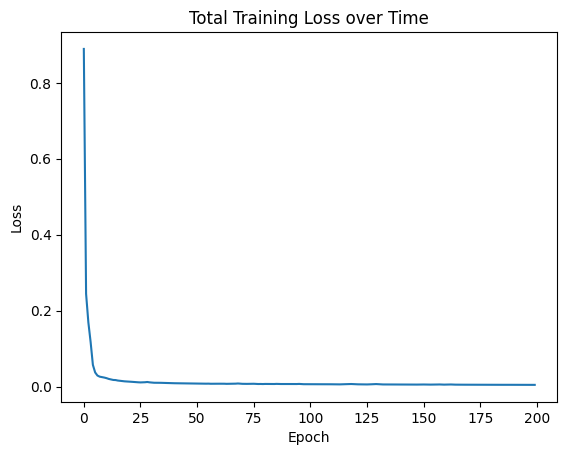

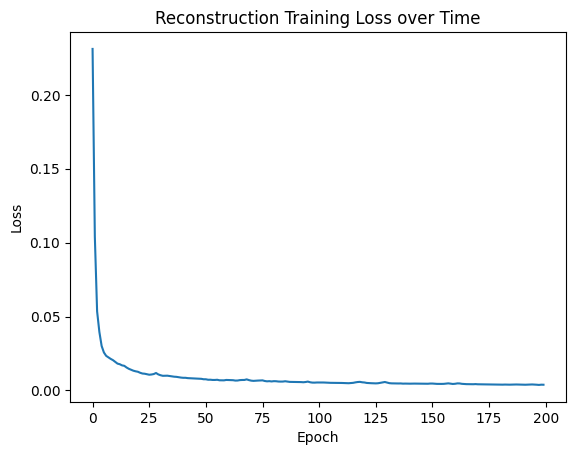

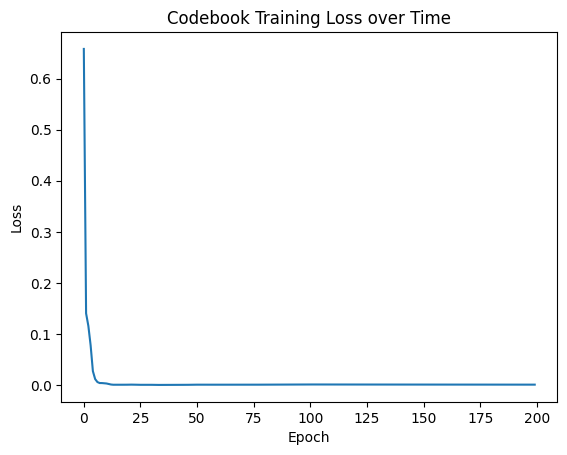

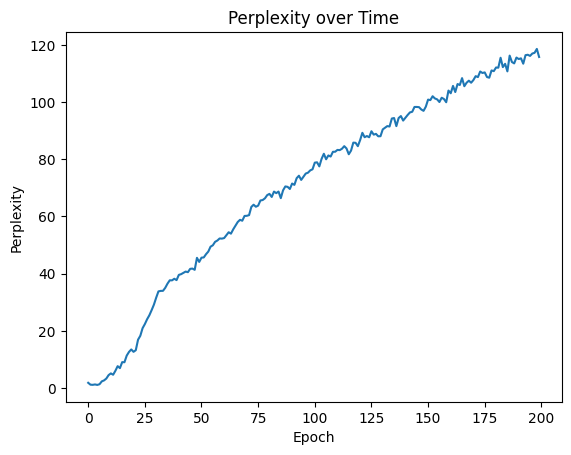

In [ ]:
# After training, plot the loss values
plt.plot(loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Training Loss over Time')
plt.show()

plt.plot(rec_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Reconstruction Training Loss over Time')
plt.show()

plt.plot(vq_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Codebook Training Loss over Time')
plt.show()

plt.plot(perplexities)
plt.xlabel('Epoch')
plt.ylabel('Perplexity')
plt.title('Perplexity over Time')
plt.show()

# Visualization

## Reconstructions

In [ ]:
def data_to_json(landmarks, video_name):
  df = pd.DataFrame(landmarks)
  json_structure = {}
  num_joints_per_hand = 21

  for col in range(df.shape[1]):  # columns --> frames
      frame_key = f"frame_{col+1}"
      json_structure[frame_key] = {}

      # Left hand joints
      for i in range(num_joints_per_hand):
          joint_key_x = f"joint_{i+1}_x_left"
          joint_key_y = f"joint_{i+1}_y_left"
          json_structure[frame_key][joint_key_x] = float(df.iloc[2*i, col])
          json_structure[frame_key][joint_key_y] = float(df.iloc[2*i+1, col])

      # Right hand joints
      for i in range(num_joints_per_hand):
          joint_key_x = f"joint_{i+1}_x_right"
          joint_key_y = f"joint_{i+1}_y_right"
          json_structure[frame_key][joint_key_x] = float(df.iloc[2*i + num_joints_per_hand*2, col])
          json_structure[frame_key][joint_key_y] = float(df.iloc[2*i+1 + num_joints_per_hand*2, col])

  json_data = json.dumps(json_structure, indent=4)

  # Generate a unique filename by appending the current timestamp
  timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M")
  unique_name = f"{video_name}_{timestamp}"

  file_path = f"{RECONSTRUCTED_DATA}/{unique_name}.json"

  with open(file_path, 'w') as json_file:
      json.dump(json_structure, json_file, indent=4)

  return file_path, unique_name

test_VQ.eval()
with torch.no_grad():
  #---train data-------------------------------------
  X_train = next(iter(train_loader)).float().to(device)
  _, recon_X_train, _ = test_VQ(X_train)

  # picks out 10 train data windows
  selected_elements = X_train[:10].cpu().numpy() # 64 x 84 x 24 --> 10 x 84 x 24
  combined_elements = np.concatenate(selected_elements, axis=1) # 10 x 84 x 24 --> 84 x 240

  # picks out 10 recon train data windows
  recon_selected_elements = recon_X_train[:10].cpu().numpy() # 64 x 84 x 24 --> 10 x 84 x 24
  recon_combined_elements = np.concatenate(recon_selected_elements, axis=1) # 10 x 84 x 24 --> 84 x 240

  # Stores the clips in json format
  json_train_X_0_path, train_X_0_name  = data_to_json(combined_elements, f"train_{TRUE_X}")
  json_train_recon_X_0_path, train_recon_X_0_name = data_to_json(recon_combined_elements, f"train_{RECON_X}")

  #---test data--------------------------------------
  X_test = next(iter(test_loader)).float().to(device)
  _, recon_X_test, _ = test_VQ(X_test)

  # picks out 10 test data windows
  selected_elements = X_test[:10].cpu().numpy() # 64 x 84 x 24 --> 10 x 84 x 24
  combined_elements = np.concatenate(selected_elements, axis=1) # 10 x 84 x 24 --> 84 x 240

  # picks out 10 recon test data windows
  recon_selected_elements = recon_X_test[:10].cpu().numpy() # 64 x 84 x 24 --> 10 x 84 x 24
  recon_combined_elements = np.concatenate(recon_selected_elements, axis=1) # 10 x 84 x 24 --> 84 x 240

  json_test_X_0_path, test_X_0_name  = data_to_json(combined_elements, f"test_{TRUE_X}")
  json_test_recon_X_0_path, test_recon_X_0_name = data_to_json(recon_combined_elements, f"test_{RECON_X}")


In [ ]:
print(recon_X_test.shape)

torch.Size([64, 84, 40])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

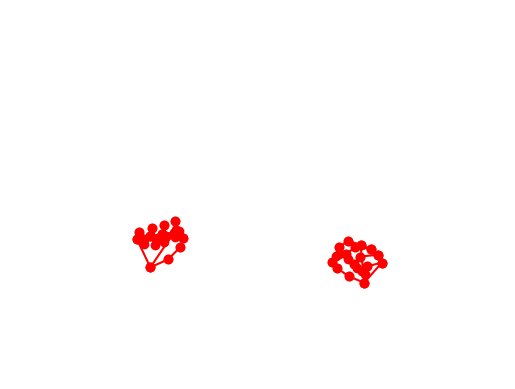

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

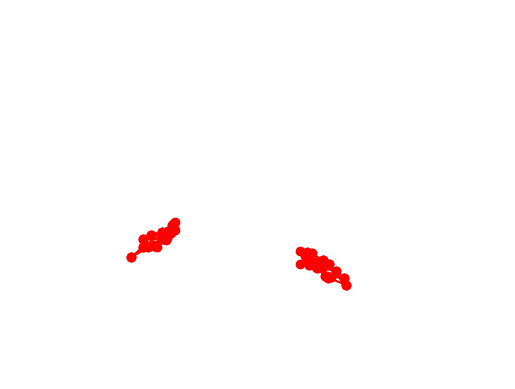

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

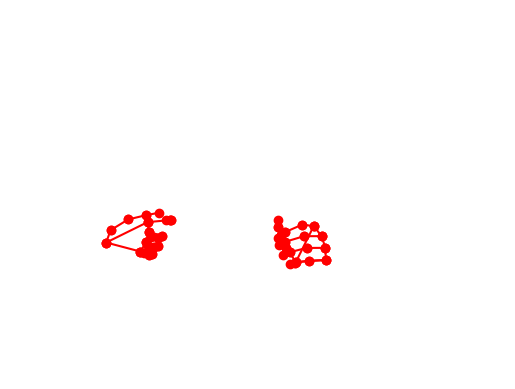

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

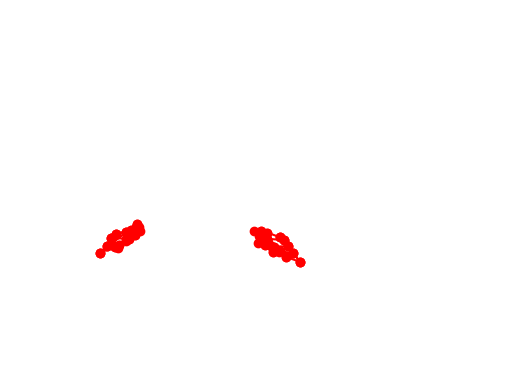

In [ ]:
def animate_landmarks(filepath, video_name):
  with open(filepath, 'r') as file:
    data = json.load(file)

  fig, ax = plt.subplots()
  ax.set_xlim(0, 1)  # Normalized coordinates
  ax.set_ylim(1, 0)

  ani = animation.FuncAnimation(fig, update_frame, frames=range(len(data)), fargs=(data, ax), blit=False)
  ani.save(f'{video_name}.mp4', writer='ffmpeg', fps=10)
  files.download(f'{video_name}.mp4')
  plt.show()

# Animate sign language
def update_frame(num, data, ax):
    ax.clear()

    ax.set_xlim(0, 1)  # Normalized coordinates
    ax.set_ylim(1, 0)

    frame_key = f"frame_{num+1}"
    if frame_key in data:
        frame_data = data[frame_key]
        draw_hand(frame_data, ax, 'left')
        draw_hand(frame_data, ax, 'right')

    ax.axis('off')

# Draw hand (handles one frame and one hand)
def draw_hand(frame_data, ax, hand):
    connections = joint_connections[hand]

    for start, end in connections:
        x_start, y_start = frame_data[f'joint_{start}_x_{hand}'], frame_data[f'joint_{start}_y_{hand}']
        x_end, y_end = frame_data[f'joint_{end}_x_{hand}'], frame_data[f'joint_{end}_y_{hand}']
        ax.plot([x_start, x_end], [y_start, y_end], 'ro-')  # Draw line between connected joints

# Define joint connection manually, got it from https://developers.google.com/mediapipe/solutions/vision/hand_landmarker
joint_connections = {
    'left': [(1, 2), (2, 3), (3, 4), (4, 5), (1, 6), (6, 7), (7, 8), (8, 9),
             (6, 10), (10, 11), (11, 12), (12, 13), (10, 14), (14, 15), (15, 16),
             (16, 17), (14, 18), (18, 19), (19, 20), (20, 21), (1, 18)],
    'right': [(1, 2), (2, 3), (3, 4), (4, 5), (1, 6), (6, 7), (7, 8), (8, 9),
             (6, 10), (10, 11), (11, 12), (12, 13), (10, 14), (14, 15), (15, 16),
             (16, 17), (14, 18), (18, 19), (19, 20), (20, 21), (1, 18)]
}

animate_landmarks(json_train_X_0_path, train_X_0_name)
animate_landmarks(json_train_recon_X_0_path, train_recon_X_0_name)
animate_landmarks(json_test_X_0_path, test_X_0_name)
animate_landmarks(json_test_recon_X_0_path, test_recon_X_0_name)

## Codebooks

In [ ]:
!pip install umap-learn
import umap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 8.7 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86832 sha256=bb9728fee438b9e8db14a9acbb97ef1f60011a5b573e38a30fbc9e8b6303624d
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn


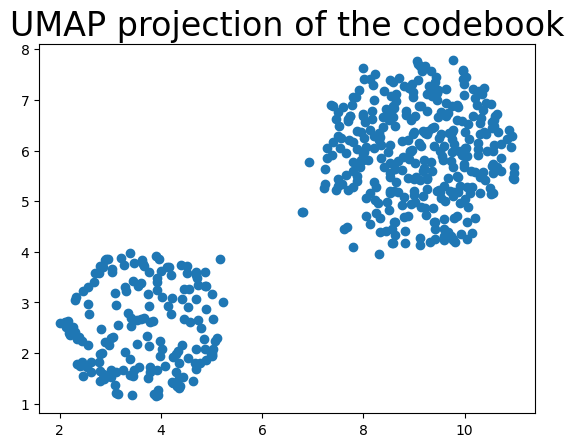

In [ ]:
# Create a UMAP reducer
reducer = umap.UMAP()

#----------------------------------------------------------------
# Convert codebook weight tensor to numpy, which umap can handle
codebook_vectors_np = test_VQ.vq.codebook.weight.data.cpu().numpy()

# Apply UMAP to the codebook vectors
embedding = reducer.fit_transform(codebook_vectors_np)

# Plot the UMAP projection
plt.scatter(embedding[:, 0], embedding[:, 1])
#----------------------------------------------------------------

plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection of the codebook", fontsize=24)
plt.show()

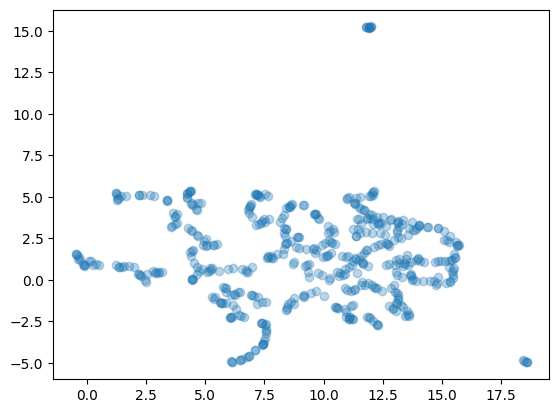

In [ ]:
proj = umap.UMAP(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(test_VQ.vq.codebook.weight.data.cpu())

plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

# Evaluation

## Frechet distance

In [ ]:
!pip install frechetdist
from frechetdist import frdist

In [ ]:
with torch.no_grad():
  frechet_distance_train = frdist(X_train.cpu().numpy(), recon_X_train.cpu().numpy())
  frechet_distance_test = frdist(X_test.cpu().numpy(), recon_X_test.cpu().numpy())

  print("frechet for train data: ", frechet_distance_train)
  print("frechet for test data: ", frechet_distance_test)

frechet for train data:  5.9766912524465665
frechet for test data:  6.504659733543483


## Jerks

In [ ]:
#TODO: need to get data output, loop over


def compute_jerks(data, dim=2):
    """Compute jerk between adjacent frames

      Args:
          data:         array containing joint positions of gesture
          dim:          gesture dimensionality

      Returns:
          np.ndarray:   jerks of each joint averaged over all frames
    """

    # Third derivative of position is jerk
    jerks = np.diff(data, n=3, axis=0)

    num_jerks = jerks.shape[1]
    num_joints = jerks.shape[0] // dim

    jerk_norms = np.zeros((num_jerks, num_joints))

    for i in range(num_joints):
        for j in range(num_jerks):
            x1 = j * dim + 0
            x2 = j * dim + dim
            jerk_norms[j,i] = np.linalg.norm(jerks[i, x1:x2])

    average = np.mean(jerk_norms, axis=0)

    # Take into account that frame rate was 25 fps
    scaled_av = average * 25 * 25 * 25

    return scaled_av

orig_res_train = compute_jerks(X_train[0].cpu().detach())
recon_res_train = compute_jerks(recon_X_train[0].cpu())
orig_res_test = compute_jerks(X_test[0].cpu().detach())
recon_res_test = compute_jerks(recon_X_test[0].cpu())
print(f"Orig_train_data:\n{np.mean(abs(orig_res_train - recon_res_train))}")
print(f"Orig_test_data:\n{np.mean(abs(orig_res_test - recon_res_test))}")

Orig_train_data:
576.702265698259
Orig_test_data:
1248.1696977920365


## Acceleration

In [ ]:
#need to get data output, loop over

def compute_acceleration(data, dim=2):
    """Compute acceleration between adjacent frames

      Args:
          data:         array containing joint positions of gesture
          dim:          gesture dimensionality

      Returns:
          np.ndarray:   accelerations of each joint averaged over all frames
    """

    # Second derivative of position is acceleration
    accs = np.diff(data, n=2, axis=0)

    num_accs = accs.shape[1]
    num_joints = accs.shape[0] // dim

    acc_norms = np.zeros((num_accs, num_joints))

    for i in range(num_joints):
        for j in range(num_accs):
            x1 = j * dim + 0
            x2 = j * dim + dim
            acc_norms[j,i] = np.linalg.norm(accs[i, x1:x2])

    average = np.mean(acc_norms, axis=0)

    # Take into account that frame rate was 25 fps
    scaled_av = average * 25 * 25

    return scaled_av


orig_res_train = compute_acceleration(X_train[0].cpu().detach())
recon_res_train = compute_acceleration(recon_X_train[0].cpu())
orig_res_test = compute_acceleration(X_test[0].cpu().detach())
recon_res_test = compute_acceleration(recon_X_test[0].cpu())
print(f"Orig_train_data:\n{np.mean(abs(orig_res_train - recon_res_train))}")
print(f"Orig_test_data:\n{np.mean(abs(orig_res_test - recon_res_test))}")

Orig_train_data:
12.166164404068073
Orig_test_data:
25.50606142229786
